# Necessary Packages

In [1]:
import pandas as pd
import numpy as np
import requests
import io
import tweepy
import json
import os.path
import nltk
import matplotlib.pyplot as plt
from ggplot import *

# Gathering data

In this project, we will use three different type of sources as follow:

* The WeRateDogs Twitter archive on hand.
* The tweet image prediction table downloaded programmatically from Udacity's servers.
* The retweet count and favorite count of each tweet via Twitter's API.

#### Load WeRateDogs Twitter archive

In [2]:
# load WeRateDogs Twitter archive.
archive = pd.read_csv('twitter_archive_enhanced.csv')
archive = archive.sort_values(by = ['tweet_id']).reset_index(drop = True)

#### Download image prediction table

In [3]:
# load image prediction table
raw_download = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
image_prediction = pd.read_csv(io.StringIO(raw_download.text), delimiter= '\t')
image_prediction = image_prediction.sort_values(by = ['tweet_id']).reset_index(drop = True)

#### Query status from Twitter server

* Setup api by setting consumer_key, consumer_secret, access_token and access_token_secret.
* Query status objects by ```API..statuses_lookup``` in tweepy API class. Get 100 status objects as most in each call.
* Write JSON data of each tweet (status) object as a single line into a txt file named ```tweet_json.txt```.
* Load ```tweet_json.txt``` to get interesing information, such as 'favorite_count', 'retweet_count' and 'tweet_id'.

In [4]:
# set up api
consumer_key = ''
consumer_secret = ''
access_token = ''
access_token_secret = ''
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [5]:
# load JSON data: if 'tweet_json.txt' does not exist, then download, otherwise just load the .txt file.
if not os.path.exists('tweet_json.txt'):
    # download JSON data into a txt file
    with open('tweet_json.txt', mode = 'w') as file:
        count = 0
        while count <= archive.shape[0] - 1:
            if count + 100 <= archive.shape[0] - 1:
                # get tweet_id list with maximum length as 100
                tweet_id_list = archive.tweet_id.loc[count:count + 99].tolist()
                # query tweet objects list by tweet_id list
                # NOTE: there might be some nonexistent status 
                status_list = api.statuses_lookup(tweet_id_list)
                for i in xrange(len(status_list)):
                    #store JSON data of each tweet object
                    json.dump(status_list[i]._json, file)
                    file.write('\n')
                count += 100
            else:
                # get the last tweet_id list
                tweet_id_list = archive.tweet_id.loc[count:archive.shape[0] - 1].tolist()
                # query tweet objects by tweet_id list
                status_list = api.statuses_lookup(tweet_id_list)
                for i in xrange(len(status_list)):
                    #store JSON data of each tweet object
                    json.dump(status_list[i]._json, file)
                    file.write('\n')
                count = archive.shape[0]
else:
    # load 'tweet_json.txt'
    with open('tweet_json.txt') as file:
        content = file.readlines()
    # remove '\n' in each line
    content = [x.strip() for x in content]
    # save json data as dataframe
    json_df_list = []
    for tweet in content:
        curr_json = json.loads(tweet)
        # get expanded_url in either extended_entities object or entities object
        if 'extended_entities' in curr_json.keys():
            expanded_url = curr_json['extended_entities']['media'][0]['expanded_url']
        elif len(curr_json['entities']['urls']) > 0:
            expanded_url = curr_json['entities']['urls'][0]['expanded_url']
        else:
            expanded_url = None
        # save information in a dictionanry for one row
        json_df_list.append({'tweet_id': curr_json['id'],
                             'favorite_count': curr_json['favorite_count'],
                             'retweet_count': curr_json['retweet_count'],
                              'expanded_url': expanded_url,
                             #'expanded_url': curr_json['entities']['urls'][0]['expanded_url'] if len(curr_json['entities']['urls']) > 0 else None,
                             #'expanded_url': curr_json['extended_entities']['media'][0]['expanded_url'] if 'extended_entities' in curr_json.keys() else None,
                             'media_url_https': curr_json['entities']['media'][0]['media_url_https'] if 'media' in curr_json['entities'].keys() else None})
    json_df = pd.DataFrame(json_df_list).sort_values(by=['tweet_id']).reset_index(drop = True)

In [6]:
# load 'tweet_json.txt'
with open('tweet_json.txt') as file:
    content = file.readlines()
# remove '\n' in each line
content = [x.strip() for x in content]
# save json data as dataframe
json_df_list = []
for tweet in content:
    curr_json = json.loads(tweet)
    # get expanded_url in either extended_entities object or entities object
    if 'extended_entities' in curr_json.keys():
        expanded_url = curr_json['extended_entities']['media'][0]['expanded_url']
    elif len(curr_json['entities']['urls']) > 0:
        expanded_url = curr_json['entities']['urls'][0]['expanded_url']
    else:
        expanded_url = None
    # save information in a dictionanry for one row
    json_df_list.append({'tweet_id': curr_json['id'],
                         'favorite_count': curr_json['favorite_count'],
                         'retweet_count': curr_json['retweet_count'],
                          'expanded_url': expanded_url,
                         #'expanded_url': curr_json['entities']['urls'][0]['expanded_url'] if len(curr_json['entities']['urls']) > 0 else None,
                         #'expanded_url': curr_json['extended_entities']['media'][0]['expanded_url'] if 'extended_entities' in curr_json.keys() else None,
                         'media_url_https': curr_json['entities']['media'][0]['media_url_https'] if 'media' in curr_json['entities'].keys() else None})
json_df = pd.DataFrame(json_df_list).sort_values(by=['tweet_id']).reset_index(drop = True)

# Assessing data

In this section, we will assess the quality of the three data source above in two ways. First, we will print the dataframes to explore if there is any data quality issue visually. Second, we will write python script to check the structure and basic information about the dataframes.

Our assessing criteria are listed below each dataframe and we record all of the issues we noticed visually and programmatically. The assessing part concerns whether the data is dirty or messy or both dirty and messy. The details can be found in the following analysis.

## Archive data

In [7]:
# Assessing data visually
archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None
1,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
3,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
4,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
5,666050758794694657,NaN,NaN,2015-11-16 00:30:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a truly beautiful English Wilson Staff...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666050758...,10,10,a,None,None,None,None
6,666051853826850816,NaN,NaN,2015-11-16 00:35:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an odd dog. Hard on the outside but lo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666051853...,2,10,an,None,None,None,None
7,666055525042405380,NaN,NaN,2015-11-16 00:49:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a Siberian heavily armored polar bear ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666055525...,10,10,a,None,None,None,None
8,666057090499244032,NaN,NaN,2015-11-16 00:55:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",My oh my. This is a rare blond Canadian terrie...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666057090...,9,10,a,None,None,None,None
9,666058600524156928,NaN,NaN,2015-11-16 01:01:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is the Rand Paul of retrievers folks! He'...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666058600...,8,10,the,None,None,None,None


At first glance, it is obvious that there are quite a lot if missing values in status, id and timestamp fields. And the dog information is not recorded in a reasonable way with wrong dog names and dog stages recorded in multiple columns.

To get a better overall understanding of this dataframe, it is better to look at its structrue programmatically.

In [8]:
# Assessing archive data programmatically
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

By using the '.info' method, we can see that the two fields about in_reply_to information only have 78 non-null rows out of 2356 rows, and other three fields about retweeted_status only have 181 non-null rows. Expanded urls also lack a few records.

We can also notice that the data type of four id fields is 'float' which should be transformed as 'int'. Otherwise, the ids will be represented in a weird form as follow:

In [9]:
# in_reply_to_status_id and in_reply_to_user_id recorded wrongly
archive[archive.in_reply_to_status_id.notnull()].sample(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
513,675870721063669760,6.757073e+17,4.196984e+09,2015-12-13 02:51:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",&amp; this is Yoshi. Another world record cont...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675870721...,11,10,None,None,None,None,None


In [10]:
# retweeted_status_id and retweeted_status_user_id recorded wrongly
archive[archive.retweeted_status_id.notnull()].sample(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1699,791780927877898241,NaN,NaN,2016-10-27 23:17:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Maddie. She gets some w...,7.467577e+17,4.196984e+09,2016-06-25 17:31:25 +0000,"https://vine.co/v/5BYq6hmrEI3,https://vine.co/...",11,10,Maddie,None,None,None,None


From above, it is clear that float type is not suitable for id fields. We will remedy it in data cleaning part.

Next, we come to the invalid dog name issue. We have visually noticed that the wrong dog names are alway some common words like 'a', 'the' and so on. My hunch is that the one who extracted those information used regular expression to retrieve words after words combinations such as 'This is'. Hence it would extract the correct dog name when the sentence is formed as 'This is Franklin.', but it would extract 'a' as the dog's name when the sentence is formed as 'This is a happy dog.' In quite a few situations, the dog names are not included in the tweets. So we can not fix the missing dog name issue. What we can do here is just delete the wrong dog names.

To distinguish the wrong dog names recorded in the large dataframe, we can count the numbers of each 'name' word. 

In [11]:
archive.name.value_counts()

None        745
a            55
Charlie      12
Lucy         11
Cooper       11
Oliver       11
Penny        10
Tucker       10
Lola         10
Bo            9
Winston       9
Sadie         8
the           8
an            7
Daisy         7
Toby          7
Buddy         7
Bailey        7
Dave          6
Leo           6
Oscar         6
Koda          6
Milo          6
Scout         6
Bella         6
Stanley       6
Jax           6
Rusty         6
Jack          6
George        5
           ... 
Cilantro      1
Clifford      1
Jerome        1
Mutt          1
Doobert       1
Bobb          1
Huxley        1
Jeremy        1
Finnegus      1
Zooey         1
Todo          1
Kanu          1
Winifred      1
Laika         1
Socks         1
Eazy          1
Kane          1
Joshwa        1
Meatball      1
Richie        1
Zara          1
Chevy         1
Edgar         1
Lili          1
Ester         1
Obi           1
Olaf          1
Zeek          1
Jennifur      1
all           1
Name: name, dtype: int64

From above, we can identify several obviously wrong names such as: 'a', 'the', 'an' and 'all'. However, we cant' identify all wrong names, because the list above hide names in the middel part. We may miss some wrong names. Here is an exmple below:

In [12]:
# show all rows with dog name as 'quite'
archive[archive.name == 'quite']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
29,666411507551481857,NaN,NaN,2015-11-17 00:24:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is quite the dog. Gets really excited whe...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666411507...,2,10,quite,None,None,None,None
2162,855459453768019968,NaN,NaN,2017-04-21 16:33:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Guys, we only rate dogs. This is quite clearly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/855459453...,12,10,quite,None,None,None,None
2186,859196978902773760,NaN,NaN,2017-05-02 00:04:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. This is quite clearly a smo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/859196978...,12,10,quite,None,None,None,None
2237,869988702071779329,NaN,NaN,2017-05-31 18:47:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: We only rate dogs. This is quit...,8.591970e+17,4.196984e+09,2017-05-02 00:04:57 +0000,https://twitter.com/dog_rates/status/859196978...,12,10,quite,None,None,None,None


To make sure we could identify all the wrong names, we will use NLTK package to extract all person names to filter most of correct names and then search wrong names in the rest of words. This will be done in cleaning part.

In the dog rates 'should' be a fraction with denominator as 10. The rates are in this form in most cases, but we still have exceptions:

* Datetime 'mm/dd' sometimes are wrongly recorded as dog rates. eg: '9/11' meaning September 11th;
* invalid rates in retweets, eg: 960/00;
* valid fractions representing other things, eg: '3 1/2 legged  Episcopalian' or '7/11' which is a convenience store name

In [13]:
# check dog rates by numerator 
archive.rating_numerator.value_counts().sort_index()

0         2
1         9
2         9
3        19
4        17
5        37
6        32
7        55
8       102
9       158
10      461
11      464
12      558
13      351
14       54
15        2
17        1
20        1
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        2
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
182       1
204       1
420       2
666       1
960       1
1776      1
Name: rating_numerator, dtype: int64

In [14]:
# check dog rates by denominator
archive.rating_denominator.value_counts().sort_index()

0         1
2         1
7         1
10     2333
11        3
15        1
16        1
20        2
40        1
50        3
70        1
80        2
90        1
110       1
120       1
130       1
150       1
170       1
Name: rating_denominator, dtype: int64

Since the majority of rates has '10' as denominator, let's have a look at tweets with other denominators.

In [15]:
archive[archive.rating_denominator != 10].sort_values('rating_denominator')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2042,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
20,666287406224695296,NaN,NaN,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an Albanian 3 1/2 legged Episcopalian...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666287406...,1,2,an,None,None,None,None
1839,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
693,682962037429899265,NaN,NaN,2016-01-01 16:30:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darrel. He just robbed a 7/11 and is i...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/682962037...,7,11,Darrel,None,None,None,None
1571,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1287,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
2013,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
692,682808988178739200,6.827884e+17,4.196984e+09,2016-01-01 06:22:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...","I'm aware that I could've said 20/16, but here...",NaN,NaN,NaN,NaN,20,16,None,None,None,None,None
757,686035780142297088,6.860340e+17,4.196984e+09,2016-01-10 04:04:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Yes I do realize a rating of 4/20 would've bee...,NaN,NaN,NaN,NaN,4,20,None,None,None,None,None
1190,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None


By checking the original tweets, we found a clue to filter wrong rates which is that the author always use the multiples of ten as denominator of dog rates. In most cases, he used ten times the number of dogs showing in figure as the denominator. We can extract dog rates again using this rule to reduce wrong records of dog rates.

## Summary of archive data quality issue

### Data quality issue: completeness

* Missing infomation in six columns: ```in_reply_to_status_id```, ```in_reply_to_user_id```, ```retweeted_status_id```, ```retweeted_status_user_id```, ```retweeted_status_timestamp``` . 

<b>This issue can't be fixed, because not every tweet is a reply to or retweet of others. The missing values are inevitable.</b>

* Missing typese of dogs, and the types should be one categorical variable recorded in one column. 

<b>This issue can't be fixed because the original text does not contain the information. However, we can add a column of to show the breed prediciton.</b>

* Missing values in ```name``` column which should have recorded dogs' name. 

<b>This issue can't be fixed because the original text does not contain the information.</b>

* Missing value in ```expanded_urls```

<b>Adding expanded_url values as 'https://twitter.com/dog_rates/status/tweet_id'</b>

### Data quality issue: validity

* ```in_reply_to_status_id```, ```in_reply_to_user_id```, ```retweeted_status_id``` and ```retweeted_status_user_id``` values should be saved as integer numbers rather than float numbers.

<b>Change data type of these three columns in the tweet information table.</b>

* ```timestamp``` and ```retweeted_status_timestamp``` values should be saved as datetime objects rather than strings.

<b>Change data type of these two columns in the tweet information table.</b>


### Data quality issue: accuracy

* Some dogs' name are recorded in a wrong way.

<b>Delete obviously wrong name like: 'a', 'the', 'an', and 'all'.</b>

* Datetime or other objects in same form are sometimes recorded wrongly as dog rates.

<b>Extract dog rates again use more strict regular expression.</b>

### Data quality issue: consistency
There is no consistency issue in the archive dataset.

### Data tidiness issue: 

* dog information should be saved in one table contains columns: ```text```, ```rating_numerator```, ```rating_denominator```, ```dog_stage```

<b>Split the origianl dataframe as two new dataframes. One stores dog information, and the other stores tweet information. </b>

* Values in ```dog_stage``` should be categorical variable which can be transformed from four columns ```doggo```, ```floofer```, ```pupper```, ```puppo```

<b>Create a new column in the dog information dataframe to store the categorical variable 'dog_stage'.</b>

* One tweet can have multiple dog stages in one observation (namely one row).

<b>We will split it them in different rows</b>

## Image prediction data

In [16]:
# Assessing image prediction table visually
image_prediction

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [17]:
# Assessing image prediction table programmtically
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.0+ KB


## Summary of image prediction data quality issue

From above observation, we can see that the image prediction data is clean and tidy. We don't need to clean it at all. We can extract dog breed prediction later for analysis or visualization.

## JSON data

In [18]:
# Assessing JSON data visually
json_df

,expanded_url,favorite_count,media_url_https,retweet_count,tweet_id
0,https://twitter.com/dog_rates/status/666020888...,2561,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,520,666020888022790149
1,https://twitter.com/dog_rates/status/666029285...,131,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,47,666029285002620928
2,https://twitter.com/dog_rates/status/666033412...,125,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,44,666033412701032449
3,https://twitter.com/dog_rates/status/666044226...,301,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,141,666044226329800704
4,https://twitter.com/dog_rates/status/666049248...,109,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,40,666049248165822465
5,https://twitter.com/dog_rates/status/666050758...,133,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,58,666050758794694657
6,https://twitter.com/dog_rates/status/666051853...,1231,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,856,666051853826850816
7,https://twitter.com/dog_rates/status/666055525...,440,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,257,666055525042405380
8,https://twitter.com/dog_rates/status/666057090...,298,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,142,666057090499244032
9,https://twitter.com/dog_rates/status/666058600...,112,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,58,666058600524156928


By viewing the printed JSON dataframe, we only observed the missing value issue in expanded url and media url fields. The missing values in expanded url will be fixed as above. However the missing values in medial url field can't be fixed, because some tweets are summary card which is does not contain a media url field in the JSON data.

Next, let's explore more data quality issue programmatically.

In [19]:
# Assessing JSON data programmatically
json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345 entries, 0 to 2344
Data columns (total 5 columns):
expanded_url       2208 non-null object
favorite_count     2345 non-null int64
media_url_https    1824 non-null object
retweet_count      2345 non-null int64
tweet_id           2345 non-null int64
dtypes: int64(3), object(2)
memory usage: 91.7+ KB


The basic structure of this dataframe illustrated above does not show us more data quality issue. The data types are correct and there is no more missing values. 

Next, let's count the numbers of 'favoriates' and 'retweet'.

In [20]:
# Assessing JSON data visually
json_df.favorite_count.value_counts()

0        170
314        4
3864       3
1011       3
1476       3
337        3
3535       3
2664       3
768        3
550        3
2932       3
1366       3
480        3
759        3
1309       2
2468       2
21727      2
3493       2
3434       2
1381       2
610        2
427        2
514        2
341        2
2647       2
28046      2
5403       2
5449       2
1392       2
3342       2
        ... 
27164      1
4635       1
6682       1
537        1
23006      1
2530       1
485        1
12108      1
9480       1
2538       1
4629       1
2540       1
14830      1
6640       1
497        1
12787      1
4597       1
505        1
2554       1
29091      1
2558       1
2562       1
515        1
23044      1
5165       1
2572       1
529        1
2580       1
533        1
28052      1
Name: favorite_count, dtype: int64

The most glaring issue here is that 170 tweets has no 'favoriates'. However, we checked the original tweets by their expanded urls. They do have non-zero favoriate counts. The reason is that the favoriate counts will only be non-zero when the tweet is from one authenticated user. We can fix this problem manually, but it is overwhelming.

In [21]:
json_df.retweet_count.value_counts()

528      5
1921     5
632      4
94       4
814      4
309      4
502      4
454      4
3818     4
2907     4
61       4
272      4
1308     4
1857     4
174      4
856      4
5600     4
58       4
1054     3
2479     3
3548     3
672      3
674      3
803      3
511      3
462      3
3386     3
93       3
535      3
885      3
        ..
1271     1
8261     1
11506    1
71       1
2124     1
77       1
6222     1
3314     1
83       1
2132     1
1279     1
2219     1
1283     1
6188     1
6336     1
13       1
2062     1
17       1
2066     1
19       1
23       1
2074     1
8219     1
8281     1
29       1
33       1
1285     1
41       1
18474    1
0        1
Name: retweet_count, dtype: int64

Not like 'favoriate_count', the retweet counts seems normal.

## Summary of JSON data quality issue

### Data quality issue: completeness

* Some records lack 'expanded_url' and 'media_url_https'

<b>The 'expanded_url' issue has been fixed above. Some tweets are summary card which could not be obtained by tweepy API, instead, we need another Twitter's crawler. </b>

### Data quality issue: validity

There is no validity issue.

### Data quality issue: accuracy

* There are 170 tweets has no 'likes' in our JSON dataframe. However, by checking the original tweet by the expanded url, we can find those tweets do have multiple 'likes'. 

<b>This can't be fixed here, because the favoriate counts will only be non-zero only if the tweet is from the authenticated user.</b>

### Data quality issue: consistency

There is no consistency issue.

### Data tidiness issue:

There is no tidiness issue.

# Cleaning data

Now let's start to deal with data quality issues listed above. We will re-organize all the data source as two tables. The first is to store tweet information. The second is to store dog information. Notice that we don't need to gather the dog information in retweets or replies.

Before we split the whole dataset into two groups, we would like to fix the dog rate quality issue by the text column first. Here we will use a more strict rule to extract valid dog rates as below:

In [22]:
# extract dog rating with denominator started as non-zero digits and ended as 0
archive[['rating_numerator', 'rating_denominator']]= archive.text.astype('str').str.extract('(\d+)/([1-9]\d?\d?0)', expand = True)
# transform the digits to integers and use 0/-1 for null value.
def transform_rating_numerator(tweet):
    if type(tweet.rating_numerator) != str:
        return 0
    else:
        return int(tweet.rating_numerator)
def transform_rating_denominator(tweet):
    if type(tweet.rating_denominator) != str:
        return -1
    else:
        return int(tweet.rating_denominator)
archive.rating_numerator = archive.apply(transform_rating_numerator, axis = 1)
archive.rating_denominator = archive.apply(transform_rating_denominator, axis = 1)
# test the cleanging results
print archive[archive.rating_denominator.isnull()].shape
print '-------------------------------------'
print archive.rating_denominator.value_counts()

(0, 17)
-------------------------------------
 10     2338
-1         3
 50        3
 80        2
 20        2
 170       1
 150       1
 130       1
 120       1
 110       1
 90        1
 70        1
 40        1
Name: rating_denominator, dtype: int64


For futher analysis, we will record the rate value in one single column as 'rating_value'.

In [23]:
# rating_value = rating_numerator/rating_denominator
archive['rating_value'] = archive.rating_numerator/archive.rating_denominator
archive.rating_value.head()

0    0.8
1    0.7
2    0.9
3    0.6
4    0.5
Name: rating_value, dtype: float64

## Tweet dataframe

Here we extract columns related to tweet basic information in archive dataframe image_prediction dataframe and JSON dataframe as follows:

In [24]:
# extract tweet information from archive
tweet_df = archive[['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls', 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp']]
# add 'jpg_url' column to tweet_df
tweet_df = tweet_df.merge(image_prediction[['tweet_id', 'jpg_url']], how = 'left',  left_on = 'tweet_id', right_on = 'tweet_id')
# merge tweet_df with json columns without 'expanded_url' and 'media_url_https' columns in json dataframe
tweet_df = tweet_df.merge(json_df[['tweet_id', 'favorite_count', 'retweet_count']], how = 'left', left_on = 'tweet_id', right_on = 'tweet_id')
tweet_df.head()

,tweet_id,timestamp,source,text,expanded_urls,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,jpg_url,favorite_count,retweet_count
0,666020888022790149,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,https://twitter.com/dog_rates/status/666020888...,NaN,NaN,NaN,NaN,NaN,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,2561.0,520.0
1,666029285002620928,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,NaN,NaN,NaN,NaN,NaN,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,131.0,47.0
2,666033412701032449,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,NaN,NaN,NaN,NaN,NaN,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,125.0,44.0
3,666044226329800704,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,NaN,NaN,NaN,NaN,NaN,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,301.0,141.0
4,666049248165822465,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,NaN,NaN,NaN,NaN,NaN,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,109.0,40.0


In [25]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 13 columns):
tweet_id                      2356 non-null int64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
expanded_urls                 2297 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
jpg_url                       2075 non-null object
favorite_count                2345 non-null float64
retweet_count                 2345 non-null float64
dtypes: float64(6), int64(1), object(6)
memory usage: 257.7+ KB


As you can see that the favoriate counts and retweeted counts need to be transform to integers after merging two dataframes. In the meanwhile, recall the previous data quality issue summary, we start to remedy these issues. First, we add missing expanded urls in a formal expression form: https://twitter.com/dog_rates/status/tweet_id.

In [26]:
# add missing expanded urls in a formal expression.
def create_expanded_url(tweet):
    if type(tweet.expanded_urls) == float and np.isnan(tweet.expanded_urls):
        url = 'https://twitter.com/dog_rates/status/' + str(tweet.tweet_id)
    else:
        url = tweet.expanded_urls
    return url
tweet_df.expanded_urls = tweet_df.copy().apply(create_expanded_url, axis = 1)

Next, we will fix invalid datatypes. Basically, we transform id fields from 'float' type to 'int' type and we transform timestamp fields from 'str' type to 'datetime' objects. One thing needed to be emphasized is that in the id fields there are missing numerical values, i.e. 'NaN' of 'float' type. To keep all data as integers in those fields, we have to replace them as integer '-1' to represent missing values. The reason we use '-1' is that all fields which should be integer type have non-positive value here. To distinguish zero value and null value, we decide to use '-1'.

In [27]:
# change invaild datatypes
test = tweet_df[tweet_df.in_reply_to_status_id.notnull()].in_reply_to_status_id
def float_to_int(item):
    if np.isnan(item):
        #replace NaN as integer -1, because NaN has type as float.
        return int(-1)
    else:
        return int(item)
tweet_df.in_reply_to_status_id = tweet_df.in_reply_to_status_id.apply(float_to_int)
tweet_df.in_reply_to_user_id = tweet_df.in_reply_to_user_id.apply(float_to_int)
tweet_df.retweeted_status_id = tweet_df.retweeted_status_id.apply(float_to_int)
tweet_df.retweeted_status_user_id = tweet_df.retweeted_status_user_id.apply(float_to_int)
tweet_df.favorite_count = tweet_df.favorite_count.apply(float_to_int)
tweet_df.retweet_count = tweet_df.retweet_count.apply(float_to_int)
tweet_df.timestamp = pd.to_datetime(tweet_df.timestamp)
tweet_df.retweeted_status_timestamp = pd.to_datetime(tweet_df.retweeted_status_timestamp)

We have finished cleanning the split tweet dataframe. Now we need to test if our cleaning is successful.

In [28]:
# test in_reply_to fields
tweet_df[tweet_df.in_reply_to_status_id > 0].sample(3)

,tweet_id,timestamp,source,text,expanded_urls,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,jpg_url,favorite_count,retweet_count
1339,746906459439529985,2016-06-26 03:22:31,"<a href=""http://twitter.com/download/iphone"" r...","PUPDATE: can't see any. Even if I could, I cou...",https://twitter.com/dog_rates/status/746906459...,746885919387574272,4196983835,-1,-1,NaT,https://pbs.twimg.com/media/Cl2LdofXEAATl7x.jpg,3112,328
2013,832088576586297345,2017-02-16 04:45:50,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,https://twitter.com/dog_rates/status/832088576...,832087547559997440,30582082,-1,-1,NaT,NaN,72,2
581,678023323247357953,2015-12-19 01:25:31,"<a href=""http://twitter.com/download/iphone"" r...",After getting lost in Reese's eyes for several...,https://twitter.com/dog_rates/status/678023323...,678021115718029312,4196983835,-1,-1,NaT,NaN,2051,427


In [29]:
# test retweeted_status fields
tweet_df[tweet_df.retweeted_status_id > 0].sample(3)

,tweet_id,timestamp,source,text,expanded_urls,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,jpg_url,favorite_count,retweet_count
2196,860981674716409858,2017-05-06 22:16:42,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Lorenzo. He's an avid nift...,https://www.gofundme.com/help-lorenzo-beat-can...,-1,-1,860563773140209664,4196983835,2017-05-05 18:36:06,NaN,0,2268
1487,761750502866649088,2016-08-06 02:27:27,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: ""Tristan do not speak to me wit...",https://twitter.com/dog_rates/status/685325112...,-1,-1,685325112850124800,4196983835,2016-01-08 05:00:14,https://pbs.twimg.com/media/CYLDikFWEAAIy1y.jpg,0,4413
1577,775898661951791106,2016-09-14 03:27:11,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: Like father (doggo), like son (...",https://twitter.com/dog_rates/status/733109485...,-1,-1,733109485275860992,4196983835,2016-05-19 01:38:16,https://pbs.twimg.com/media/CiyHLocU4AI2pJu.jpg,0,17407


By viewing the two samples above, we can see that the id fields have been fixed. 

In [30]:
# programmatically test the cleaing code above
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 13 columns):
tweet_id                      2356 non-null int64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
expanded_urls                 2356 non-null object
in_reply_to_status_id         2356 non-null int64
in_reply_to_user_id           2356 non-null int64
retweeted_status_id           2356 non-null int64
retweeted_status_user_id      2356 non-null int64
retweeted_status_timestamp    181 non-null datetime64[ns]
jpg_url                       2075 non-null object
favorite_count                2356 non-null int64
retweet_count                 2356 non-null int64
dtypes: datetime64[ns](2), int64(7), object(4)
memory usage: 257.7+ KB


We also noticed that there are some invalid retweet counts and favorite counts as negative number. This issue happens to some retweets. We can only view the retweets by 'https://twitter.com/dog_rates/status/retweeted_status_id'. When using 'https://twitter.com/dog_rates/status/tweet_id', we can not get anything. This may happen when the original tweets have been deleted. So we just treat these orignial tweets as 'deleted tweets' and remove them from the table. 

In [31]:
tweet_df[tweet_df.retweet_count < 0]

,tweet_id,timestamp,source,text,expanded_urls,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,jpg_url,favorite_count,retweet_count
1571,775096608509886464,2016-09-11 22:20:06,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",https://twitter.com/dog_rates/status/740373189...,-1,-1,740373189193256960,4196983835,2016-06-08 02:41:38,NaN,-1,-1
1789,802247111496568832,2016-11-25 20:26:31,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Everybody drop what you're doin...,https://twitter.com/dog_rates/status/779056095...,-1,-1,779056095788752896,4196983835,2016-09-22 20:33:42,https://pbs.twimg.com/media/Cs_DYr1XEAA54Pu.jpg,-1,-1
1973,827228250799742977,2017-02-02 18:52:38,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Phil. He's an important...,https://twitter.com/dog_rates/status/694669722...,-1,-1,694669722378485760,4196983835,2016-02-02 23:52:22,NaN,-1,-1
2057,837012587749474308,2017-03-01 18:52:06,"<a href=""http://twitter.com/download/iphone"" r...",RT @KennyFromDaBlok: 14/10 h*ckin good hats. w...,https://twitter.com/KennyFromDaBlok/status/837...,-1,-1,837011344666812416,726634734,2017-03-01 18:47:10,https://pbs.twimg.com/media/C52pYJXWgAA2BEf.jpg,-1,-1
2095,842892208864923648,2017-03-18 00:15:37,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Stephan. He just wants ...,https://twitter.com/dog_rates/status/807106840...,-1,-1,807106840509214720,4196983835,2016-12-09 06:17:20,https://pbs.twimg.com/ext_tw_video_thumb/80710...,-1,-1
2108,845459076796616705,2017-03-25 02:15:26,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Here's a heartwarming scene of ...,https://twitter.com/dog_rates/status/756288534...,-1,-1,756288534030475264,4196983835,2016-07-22 00:43:32,NaN,-1,-1
2200,861769973181624320,2017-05-09 02:29:07,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: ""Good afternoon class today we'...",https://twitter.com/dog_rates/status/806629075...,-1,-1,806629075125202944,4196983835,2016-12-07 22:38:52,https://pbs.twimg.com/media/CzG425nWgAAnP7P.jpg,-1,-1
2223,866816280283807744,2017-05-23 00:41:20,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Jamesy. He gives a kiss...,https://twitter.com/dog_rates/status/866450705...,-1,-1,866450705531457536,4196983835,2017-05-22 00:28:40,NaN,-1,-1
2237,869988702071779329,2017-05-31 18:47:24,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: We only rate dogs. This is quit...,https://twitter.com/dog_rates/status/859196978...,-1,-1,859196978902773760,4196983835,2017-05-02 00:04:57,NaN,-1,-1
2260,873697596434513921,2017-06-11 00:25:14,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,https://twitter.com/dog_rates/status/868880397...,-1,-1,868880397819494400,4196983835,2017-05-28 17:23:24,https://pbs.twimg.com/media/DA7iHL5U0AA1OQo.jpg,-1,-1


In [32]:
# remove nonexistent tweets
tweet_df = tweet_df[tweet_df.retweet_count >= 0]

By viewing the basic information of tweet dataframe, we confirmed that missing expanded urls have been added and invalid data types has been remedied.

In [33]:
# visually check the modified tweet data
tweet_df.head()

,tweet_id,timestamp,source,text,expanded_urls,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,jpg_url,favorite_count,retweet_count
0,666020888022790149,2015-11-15 22:32:08,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,https://twitter.com/dog_rates/status/666020888...,-1,-1,-1,-1,NaT,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,2561,520
1,666029285002620928,2015-11-15 23:05:30,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,-1,-1,-1,-1,NaT,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,131,47
2,666033412701032449,2015-11-15 23:21:54,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,-1,-1,-1,-1,NaT,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,125,44
3,666044226329800704,2015-11-16 00:04:52,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,-1,-1,-1,-1,NaT,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,301,141
4,666049248165822465,2015-11-16 00:24:50,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,-1,-1,-1,-1,NaT,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,109,40


## Dog dataframe

First, let's filter replied and retweets, because the 'formal' dog information is only contained in original tweets.

In [34]:
# filter replies and retweets
origin_tweet = archive[archive.in_reply_to_status_id.astype('str') == 'nan']
origin_tweet = origin_tweet[origin_tweet.retweeted_status_id.astype('str') == 'nan']

In [35]:
#check if we filtered all replies and retweets
origin_tweet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 18 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
rating_value                  2097 non-n

As you can see above, no tweets in this dataframe contains retweeted_status fields or in_reply_to fields.

In [36]:
# extract columns of dog information from origin_tweet dataframe
dog_df = origin_tweet[['tweet_id', 'rating_numerator', 'rating_denominator', 'rating_value', 'name', 'doggo', 'floofer', 'pupper', 'puppo']]
# add image prediction results to dog_df
dog_df = dog_df.merge(image_prediction[['tweet_id', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']], how = 'left', on = 'tweet_id')
dog_df.head()

,tweet_id,rating_numerator,rating_denominator,rating_value,name,doggo,floofer,pupper,puppo,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,8,10,0.8,None,None,None,None,None,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,7,10,0.7,a,None,None,None,None,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,9,10,0.9,a,None,None,None,None,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,6,10,0.6,a,None,None,None,None,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,5,10,0.5,None,None,None,None,None,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [37]:
dog_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 18 columns):
tweet_id              2097 non-null int64
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
rating_value          2097 non-null float64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
p1                    1971 non-null object
p1_conf               1971 non-null float64
p1_dog                1971 non-null object
p2                    1971 non-null object
p2_conf               1971 non-null float64
p2_dog                1971 non-null object
p3                    1971 non-null object
p3_conf               1971 non-null float64
p3_dog                1971 non-null object
dtypes: float64(4), int64(3), object(11)
memory usage: 311.3+ KB


In [38]:
# add a column to record tweets does not show dog stage
def pre_organize_dog_stage(tweet):
    if tweet.doggo == 'None' and tweet.floofer == 'None' and tweet.pupper == 'None' and tweet.puppo == 'None':
        return 'null_stage'
    else:
        return 'None'
dog_df['null_stage'] = dog_df.apply(pre_organize_dog_stage, axis = 1)

In [39]:
# change dog stage to categorical value recorded in one column.
dog_df = pd.melt(dog_df, id_vars = ['tweet_id', 'rating_numerator', 'rating_denominator', 'rating_value', 'name', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], value_vars = ['doggo', 'floofer', 'pupper', 'puppo', 'null_stage'])
colnames = dog_df.columns.tolist()
colnames[-2] = 'stage'
dog_df.columns = colnames

In [40]:
# remove rows with 'None' in value column and delete value column
dog_df = dog_df[dog_df.value != 'None']
dog_df = dog_df.drop('value', 1)

After re-organizing the dog information in dog_df, we thought everything should be good. However, it is not. In the next cell, you can see one tweet may have multiple dog stage inforamtion. There could be more than one dogs in the tweet figure, so we have to go through each tweet manually. The most important point is the computer which extracted the dog stage information will be fooled by human's humor. Hence,We can't confirm the records of dog stage are correct. Although we can only review tweets with text contains multiple dog stage words, because go through all of the tweets is time-consuming. 

Because there may exists complex situation in those tweets, let's list our cleaning criteria below:

* When encountering multiple dogs in one tweet, we will keep multiple records with same tweet id and prediction but with different dog stage information. We will only delete the actually wrong dog stages that do not match the dog in the figures.

* If the figure in a tweet does not illustrate a dog, we will delete all valid dog stage information and record the stage as 'null_stage'

In [41]:
multiple_stages = dog_df[dog_df.tweet_id.duplicated()]
multiple_stages

,tweet_id,rating_numerator,rating_denominator,rating_value,name,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,stage
4032,854010172552949760,11,10,1.1,None,English_springer,0.354733,True,collie,0.177538,True,Border_collie,0.131706,True,floofer
5393,733109485275860992,12,10,1.2,None,golden_retriever,0.945523,True,Labrador_retriever,0.042319,True,doormat,0.003956,False,pupper
5442,741067306818797568,12,10,1.2,just,golden_retriever,0.843799,True,Labrador_retriever,0.052956,True,kelpie,0.035711,True,pupper
5542,751583847268179968,5,10,0.5,None,dalmatian,0.868304,True,studio_couch,0.059623,False,snow_leopard,0.013876,False,pupper
5601,759793422261743616,12,10,1.2,Maggie,golden_retriever,0.985876,True,Labrador_retriever,0.001948,True,kuvasz,0.001752,True,pupper
5728,781308096455073793,12,10,1.2,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pupper
5754,785639753186217984,10,10,1.0,Pinot,porcupine,0.978042,False,sea_urchin,0.006106,False,echidna,0.005442,False,pupper
5844,801115127852503040,12,10,1.2,Bones,dalmatian,0.823356,True,English_setter,0.094602,True,bluetick,0.021953,True,pupper
5874,808106460588765185,12,10,1.2,None,golden_retriever,0.426183,True,Labrador_retriever,0.257447,True,Great_Pyrenees,0.126482,True,pupper
5932,817777686764523521,13,10,1.3,Dido,curly-coated_retriever,0.733256,True,flat-coated_retriever,0.214145,True,Irish_water_spaniel,0.029769,True,pupper


After checking dog stage manually in each tweet, we get the invalid row number list as follow:

In [42]:
# list all the invalid dog stage
# delete_list= [{'tweet_id':854010172552949760, 'stage': 'floofer'},
#                  {'tweet_id':751583847268179968, 'stage': 'pupper'},
#                  {'tweet_id':785639753186217984, 'stage': 'doggo'},
#                  {'tweet_id':801115127852503040, 'stage': 'doggo'},
#                  {'tweet_id':817777686764523521, 'stage': 'doggo'},
#                  {'tweet_id':855851453814013952, 'stage': 'doggo'}]
delete_index = [4032, 5542, 1560, 1650, 1738, 1942]
# change_list = [{'tweet_id':785639753186217984, 'stage': 'null_stage'}]
change_index = [5754]
# delete invalid rows
dog_df = dog_df.drop(delete_index)
# modifiy invalid rows
dog_df.set_value(change_index[0], 'stage', 'null_stage') 

,tweet_id,rating_numerator,rating_denominator,rating_value,name,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,stage
1109,716080869887381504,11,10,1.1,None,golden_retriever,0.638625,True,chow,0.254717,True,Tibetan_mastiff,0.071732,True,doggo
1137,719991154352222208,10,10,1.0,None,golden_retriever,0.605304,True,cocker_spaniel,0.130948,True,Labrador_retriever,0.094692,True,doggo
1157,724771698126512129,11,10,1.1,None,German_short-haired_pointer,0.835491,True,bluetick,0.058788,True,English_setter,0.037208,True,doggo
1172,727644517743104000,13,10,1.3,None,Great_Pyrenees,0.457164,True,kuvasz,0.391710,True,Labrador_retriever,0.094523,True,doggo
1195,732375214819057664,11,10,1.1,Kyle,tennis_ball,0.998673,False,basset,0.000547,True,golden_retriever,0.000360,True,doggo
1199,733109485275860992,12,10,1.2,None,golden_retriever,0.945523,True,Labrador_retriever,0.042319,True,doormat,0.003956,False,doggo
1209,735256018284875776,8,10,0.8,Kellogg,Staffordshire_bullterrier,0.523191,True,French_bulldog,0.351104,True,doormat,0.028075,False,doggo
1232,739238157791694849,13,10,1.3,None,Eskimo_dog,0.503372,True,Siberian_husky,0.390413,True,malamute,0.080901,True,doggo
1236,739623569819336705,12,10,1.2,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,doggo
1248,741067306818797568,12,10,1.2,just,golden_retriever,0.843799,True,Labrador_retriever,0.052956,True,kelpie,0.035711,True,doggo


After modifying the invalid dog stages, let's test if our modification works.

In [43]:
dog_df.loc[5754]

tweet_id              785639753186217984
rating_numerator                      10
rating_denominator                    10
rating_value                           1
name                               Pinot
p1                             porcupine
p1_conf                         0.978042
p1_dog                             False
p2                            sea_urchin
p2_conf                        0.0061063
p2_dog                             False
p3                               echidna
p3_conf                       0.00544197
p3_dog                             False
stage                         null_stage
Name: 5754, dtype: object

As you can see, we successfully changed an invalid stage to 'null_stage'. The corresponding tweet figure actually shows a hedgehog rather than a dog.

In [44]:
dog_df[dog_df.tweet_id.duplicated()]

,tweet_id,rating_numerator,rating_denominator,rating_value,name,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,stage
5393,733109485275860992,12,10,1.2,None,golden_retriever,0.945523,True,Labrador_retriever,0.042319,True,doormat,0.003956,False,pupper
5442,741067306818797568,12,10,1.2,just,golden_retriever,0.843799,True,Labrador_retriever,0.052956,True,kelpie,0.035711,True,pupper
5601,759793422261743616,12,10,1.2,Maggie,golden_retriever,0.985876,True,Labrador_retriever,0.001948,True,kuvasz,0.001752,True,pupper
5728,781308096455073793,12,10,1.2,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pupper
5874,808106460588765185,12,10,1.2,None,golden_retriever,0.426183,True,Labrador_retriever,0.257447,True,Great_Pyrenees,0.126482,True,pupper


Now one can check the rows with duplicated tweet id actually shows the dog information for the second dog in the corresponding tweet figure. One can manually check it by link 'https://twitter.com/dog_rates/status/tweet_id' where the tweet_ids can be find in the above dataframe.

After the modifying, now we need to sort the dataframe by tweet_id and reset index.

In [45]:
dog_df = dog_df.sort_values('tweet_id').reset_index(drop = True)
dog_df

,tweet_id,rating_numerator,rating_denominator,rating_value,name,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,stage
0,666020888022790149,8,10,0.8,None,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,null_stage
1,666029285002620928,7,10,0.7,a,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,null_stage
2,666033412701032449,9,10,0.9,a,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,null_stage
3,666044226329800704,6,10,0.6,a,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,null_stage
4,666049248165822465,5,10,0.5,None,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,null_stage
5,666050758794694657,10,10,1.0,a,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True,null_stage
6,666051853826850816,2,10,0.2,an,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False,null_stage
7,666055525042405380,10,10,1.0,a,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False,null_stage
8,666057090499244032,9,10,0.9,a,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True,null_stage
9,666058600524156928,8,10,0.8,the,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True,null_stage


Next, we will start to deal with the invalid dog name issue. Here we will use Python package 'nltk' to analyze the what types of the word are of the dog names.

In [46]:
def dog_name_type(tweet):
    return nltk.pos_tag(nltk.word_tokenize(tweet['name']))[0][1]
# record word type of 'name' values
dog_df['name_type'] = dog_df.apply(dog_name_type, axis = 1)
# show the number of 'name values in each type
dog_df.name_type.value_counts()

NN      1576
NNP      306
DT        71
NNS       47
RB        38
JJ        24
VB        21
VBN        5
CD         4
IN         3
VBG        3
PRP$       2
FW         1
VBD        1
Name: name_type, dtype: int64

The meaning of part-of-speech tags can be found [here](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html). The reasonable dog names can only be 'NN' or 'NNP' type. We should clean the dog name data by setting 'name' values in other type to 'None'.

In [47]:
# delete invalide dog names
def change_dog_name(tweet):
    if tweet.name_type not in ['NN', 'NNP']:
        return 'None'
    else:
        return tweet['name']

dog_df['name'] = dog_df.apply(change_dog_name, axis = 1)
dog_df = dog_df.drop(['name_type'], 1)

In [48]:
# check dog names again
dog_df['name'].value_counts()

None         826
Charlie       11
Lucy          11
Cooper        10
Oliver        10
Tucker         9
Penny          9
Winston        8
Sadie          8
Lola           8
Toby           7
Daisy          7
Bella          6
Bailey         6
Oscar          6
Jax            6
Bo             6
Koda           6
Stanley        6
Maggie         5
Buddy          5
Bentley        5
Chester        5
Rusty          5
Scout          5
Louis          5
Milo           5
Leo            5
Winnie         4
Bear           4
            ... 
Bobb           1
Ziva           1
Nimbus         1
Godzilla       1
Pavlov         1
Suki           1
Creg           1
Alexander      1
Finnegus       1
Moreton        1
Lenox          1
Clyde          1
Livvie         1
Brudge         1
Lili           1
Grizzie        1
Mollie         1
Teddy          1
Snoop          1
Jeremy         1
Kane           1
Philbert       1
Naphaniel      1
Todo           1
Kanu           1
Dawn           1
Lilah          1
Steve         

From above, we can see that the dog names change been changed. However, in order to confirm the correctness of dog names in 100 percent sure, we have to go through all rows manually.

Next, we will create a columns to show the most reasonable dog breed by the image prediction results. Our plan is to select a real dog breed in prediction with highest probability. If none of the three predictions in the dataframe shows a real dog breed, we will record the dog breed as 'not_dog'.

In [49]:
def breed_prediction(tweet):
    if tweet.p1_dog:
        return tweet.p1
    if tweet.p2_dog:
        return tweet.p2
    if tweet.p3_dog:
        return tweet.p3
    return 'not_dog'

dog_df['breed_prediction'] = dog_df.apply(breed_prediction, axis = 1)
dog_df

,tweet_id,rating_numerator,rating_denominator,rating_value,name,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,stage,breed_prediction
0,666020888022790149,8,10,0.8,None,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,null_stage,Welsh_springer_spaniel
1,666029285002620928,7,10,0.7,None,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,null_stage,redbone
2,666033412701032449,9,10,0.9,None,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,null_stage,German_shepherd
3,666044226329800704,6,10,0.6,None,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,null_stage,Rhodesian_ridgeback
4,666049248165822465,5,10,0.5,None,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,null_stage,miniature_pinscher
5,666050758794694657,10,10,1.0,None,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True,null_stage,Bernese_mountain_dog
6,666051853826850816,2,10,0.2,None,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False,null_stage,not_dog
7,666055525042405380,10,10,1.0,None,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False,null_stage,chow
8,666057090499244032,9,10,0.9,None,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True,null_stage,golden_retriever
9,666058600524156928,8,10,0.8,None,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True,null_stage,miniature_poodle


# Data Visualization

Now we can use the cleaned data for data visualization. 

### How popular is the tweet account '@dog_rates' ?

To explore how popular is this account, we could use histograme to show the distribution of favorite counts and retweet counts. Since the two distributions are both long-tailed, we will use log scale on x-axis for better visualization.

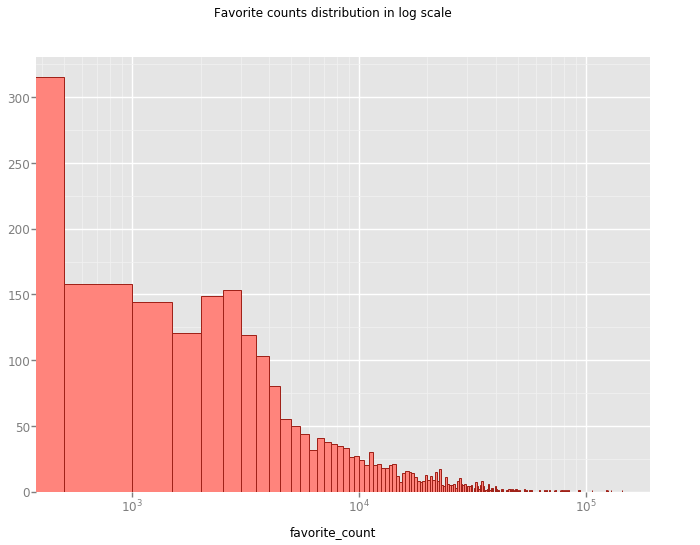

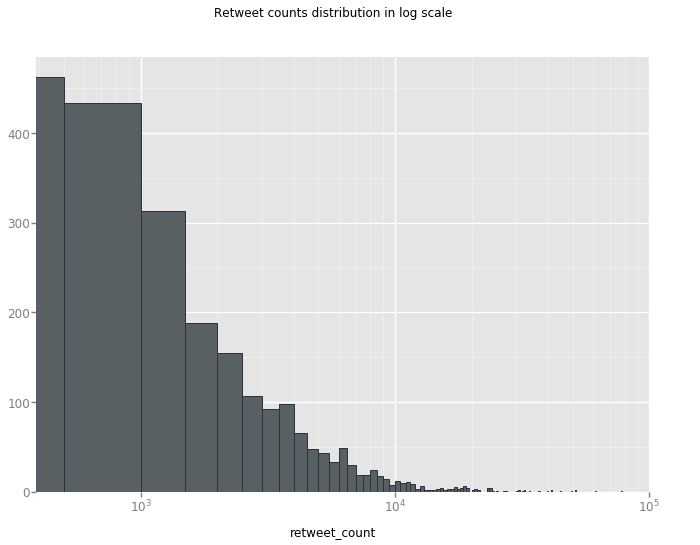

In [50]:
fig1 = ggplot(aes(x = 'favorite_count'), data = tweet_df) +\
    geom_histogram(fill = '#FF847C', color = '#a02219', binwidth = 500) +\
    scale_x_log() +\
    ggtitle('Favorite counts distribution in log scale')

fig2 = ggplot(aes(x = 'retweet_count'), data = tweet_df) +\
    geom_histogram(fill = '#586063', color = '#2A363B', binwidth = 500) +\
    scale_x_log() +\
    ggtitle('Retweet counts distribution in log scale')
plt.figure()
fig1.make()
plt.show()
fig2.make()
plt.show()

As you can see, there are large data chunks on the left hand side of each plot. On average, this tweet count is quite popular with audiences over thousands.

Next, we will show desicriptive statistics of non-zero favoriate counts and retweet counts.

In [51]:
non_zero_favorite_count = tweet_df[tweet_df.favorite_count > 0].favorite_count
non_zero_favorite_count.describe()

count      2175.000000
mean       8722.727816
std       12417.355773
min          51.000000
25%        1874.000000
50%        3964.000000
75%       10910.000000
max      143791.000000
Name: favorite_count, dtype: float64

In [52]:
tweet_df.retweet_count.describe()

count     2345.000000
mean      3037.573561
std       5051.502874
min          0.000000
25%        608.000000
50%       1422.000000
75%       3539.000000
max      77620.000000
Name: retweet_count, dtype: float64

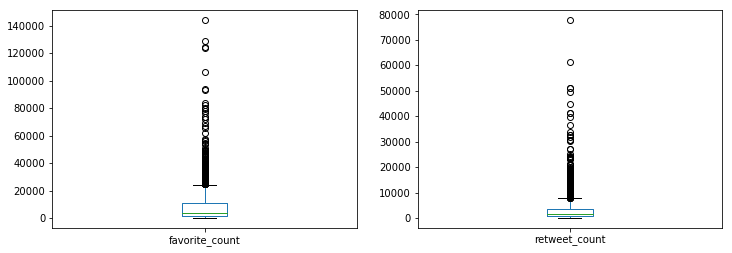

In [53]:
# use boxplot the show descriptive statistics of favorite counts and retweet counts
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
non_zero_favorite_count.plot.box(ax = ax1)
tweet_df.retweet_count.plot.box(ax = ax2)
plt.show()

By the decriptive statistics and box plots shown above, we can again confirm that the data points are highly skewed and the median audience size which is measured by median of non-zero favorite counts is around 4000.

Another interest of our analysis is to figure out how does @dog_rates' audience size increase along time.

In [54]:
# create time series to show the data
audience_size = tweet_df[['timestamp', 'favorite_count', 'retweet_count']]
audience_size

,timestamp,favorite_count,retweet_count
0,2015-11-15 22:32:08,2561,520
1,2015-11-15 23:05:30,131,47
2,2015-11-15 23:21:54,125,44
3,2015-11-16 00:04:52,301,141
4,2015-11-16 00:24:50,109,40
5,2015-11-16 00:30:50,133,58
6,2015-11-16 00:35:11,1231,856
7,2015-11-16 00:49:46,440,257
8,2015-11-16 00:55:59,298,142
9,2015-11-16 01:01:59,112,58


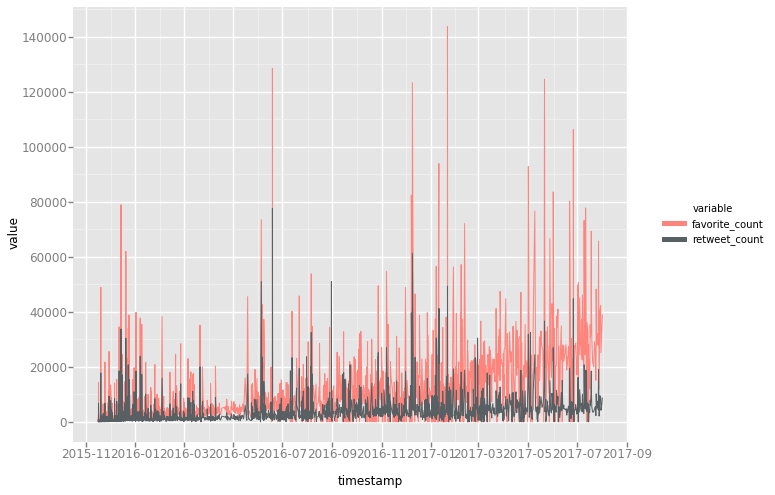

<ggplot: (290524329)>

In [55]:
audience_size_long = pd.melt(audience_size, id_vars = ['timestamp'])
ggplot(aes(x = 'timestamp', y = 'value', color = 'variable'), data = audience_size_long) +\
    geom_line() +\
    scale_color_manual(values = ['#FF847C', '#586063'])

By plotting the time series data, we can draw a conclusion that the favorite counts and retweet counts increases as time goes on. The increasing of favorite counts is significant in 2017.

### How does '@dog_rates' rate dogs?

By viewing the original tweets from '@dog_rates', we can find that its tweets are always full of humor. In some cases the author may not rate dogs in a reasonable way just for adding jokes. In other cases, when the figures are not dogs, the scores have high probability to be low. To be fair, we will split the whole tweets samples into two groups to see how the author judge the figures. One group for real dog breeds and the other for others which are not dogs. The splitting criterion is based on the 'breed_prediction' column in dog inforamtion dataframe.

In [56]:
# split the whole sample into two subgroups.
def check_isDog(tweet):
    if tweet.breed_prediction == 'not_dog':
        return 'Others'
    else:
        return 'Real dog'
dog_df['isDog'] = dog_df.apply(check_isDog, axis = 1)

Next, let's identify the outlier rates in each group and exclude them in the histogram for better visualization.

In [57]:
# check outliers in dog_group
dog_df[dog_df.isDog == 'Real dog'].rating_value.value_counts().sort_index()

-0.0      2
 0.2      3
 0.3      5
 0.4      6
 0.5     15
 0.6     16
 0.7     31
 0.8     71
 0.9    136
 1.0    380
 1.1    378
 1.2    469
 1.3    255
 1.4     27
 2.6      1
 2.7      1
 7.5      1
Name: rating_value, dtype: int64

In [58]:
# check outliers in non_dog_group
dog_df[dog_df.isDog == 'Others'].rating_value.value_counts().sort_index()

0.1       4
0.2       7
0.3      14
0.4       9
0.5      19
0.6      16
0.7      20
0.8      27
0.9      18
1.0      59
1.1      40
1.2      26
1.3      32
1.4      12
42.0      1
177.6     1
Name: rating_value, dtype: int64

In [63]:
dog_df.isDog.value_counts()

Real dog    1797
Others       305
Name: isDog, dtype: int64

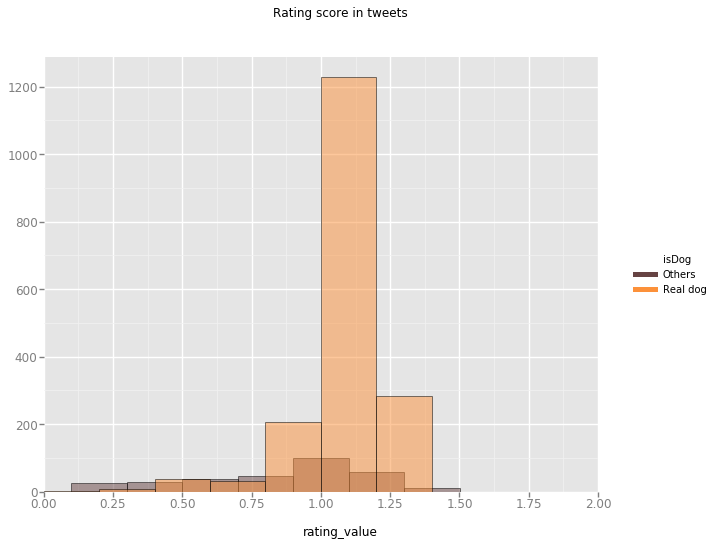

<ggplot: (299339993)>

In [59]:
ggplot(aes(x = 'rating_value', fill = 'isDog'), data = dog_df) +\
    geom_histogram(binwidth = 0.2, alpha = 0.5, color = 'black') +\
    xlim(0,2) +\
    scale_fill_manual(values = ['#664343','#FC913A']) +\
    ggtitle('Rating score in tweets')

As we can see above, the majority of rates of either real dogs or other animals/objects are from 0.75 to 1.25. The peak of real dog rates is a little higher than others, since the peak of real dog rates is on the right hand side of the other's. In a word, we can tell that @dog_rates trend to give higher scores to real dogs but still the author is very tolerant when rating whatever he got in the figure. 

### Which dog breed is the most popular one?

First of all, we will create a pie chart to show the proportion of top 10 dog breeds (including 'not_dog') shown in the tweet samples.

In [60]:
# select top 10 breeds
topBreed_list = dog_df.breed_prediction.value_counts().index.tolist()[0:9]

# save the top 10 breeds counts as a pandas series
def find_top_breed(tweet):
    if tweet.breed_prediction in topBreed_list:
        return tweet.breed_prediction
    else:
        return 'Other dog breeds'
dog_df['top_breed'] = dog_df.apply(find_top_breed, axis = 1)
top_breed= dog_df.top_breed.value_counts()
top_breed

Other dog breeds      1145
not_dog                305
golden_retriever       160
Labrador_retriever     106
Pembroke                94
Chihuahua               90
pug                     62
toy_poodle              50
chow                    48
Samoyed                 42
Name: top_breed, dtype: int64

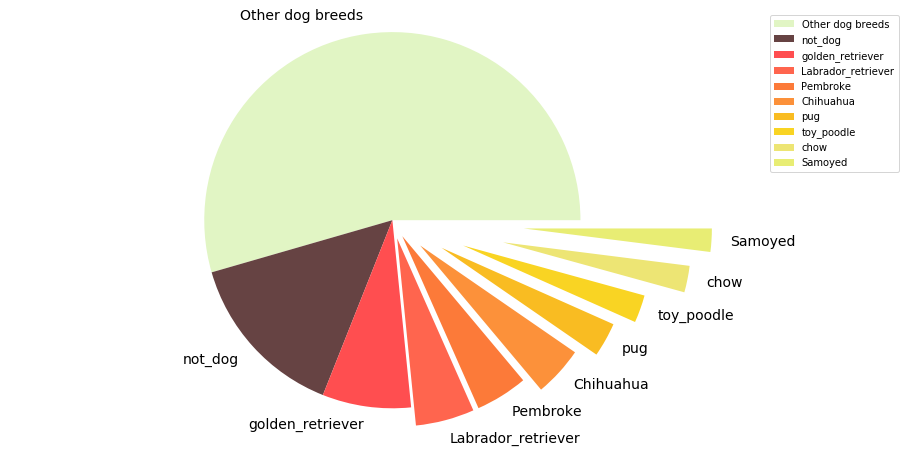

In [68]:
# create a pie chart to show the proportion of top 10 breeds
explode = (0, 0, 0, 0.1, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7)
colors = ['#E1F5C4', '#664343', '#FF4E50', '#ff654e', '#fc7a39', '#FC913A', '#f9bc22', '#f9d423',
          '#EDE574', '#e8ed74']
fig = plt.figure(figsize = (16,8))
top_breed.plot(kind='pie', fontsize=14, colors=colors, explode=explode)
plt.axis('equal')
plt.ylabel('')
plt.legend(labels=top_breed.index, loc="best")
plt.show()
fig.savefig('piechart.png')

From the pie chart, you may notice that:

* @dog_rates has a large proportion of tweets which judges animals/objects that are not dogs.
* the most popular dog breed shown in @dog_rates' tweets is golden retriever
* The @dog_rates rated a lot of dogs in various breeds. There are actually 114 breeds in total which can be checked by the dog_df dataframe.

In the end, we will save the dataframes as csv files.

In [69]:
tweet_df.to_csv('twitter_archive_master.csv')
dog_df.to_csv('dog_inforamtion_master.csv')